#### Task 2: Comparative Analysis of Google and Baidu
- Objective:
- Compare the response patterns of Google and Baidu in their autocomplete suggestions.
- Actions:Common Groups Analysis:
 - Identify common social or thematic groups in suggestions from both platforms. Count the number of these common groups.
- Chi-test for Negative Ratio:
 - Conduct a T-test for the negative ratio in English on Google and Chinese on Baidu.
- Distribution Analysis:
- Evaluate how suggestions are distributed among different social or thematic groups.

In [1]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import fisher_exact
from collections import defaultdict

# Load datasets
baidu_file_path = '../data/baidu/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '../data/google/google_follow_query.csv'  # Replace with your file path

baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# Convert 'sentiment_rating_full_suggestion' to numeric type in both datasets
baidu_df['sentiment_rating_full_suggestion'] = pd.to_numeric(baidu_df['sentiment_rating_full_suggestion'], errors='coerce')
google_df['sentiment_rating_full_suggestion'] = pd.to_numeric(google_df['sentiment_rating_full_suggestion'], errors='coerce')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# Function to calculate the number of negative sentiments and total sentiments
def calculate_counts(df, category, sentiment_col):
    negative_count = df[df[sentiment_col] == 3.0]['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    return negative_count, total_count

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Performing Fisher's Exact Test and Z-test for proportions for each category
fisher_exact_results = defaultdict(dict)
z_test_results = defaultdict(dict)
for category in unique_categories:
    # Fisher's Exact Test
    baidu_table = create_contingency_table(baidu_common, category, 'sentiment_rating_full_suggestion')
    google_table = create_contingency_table(google_common, category, 'sentiment_rating_full_suggestion')
    oddsratio, fisher_p_value = fisher_exact([baidu_table, google_table]) if sum(baidu_table) > 0 and sum(google_table) > 0 else (float('nan'), 1.0)
    fisher_exact_results[category]['Odds Ratio'] = oddsratio
    fisher_exact_results[category]['P-value'] = fisher_p_value

    # Z-test for Proportions
    baidu_neg, baidu_total = calculate_counts(baidu_common, category, 'sentiment_rating_full_suggestion')
    google_neg, google_total = calculate_counts(google_common, category, 'sentiment_rating_full_suggestion')
    z_stat, z_p_value = sm.stats.proportions_ztest([baidu_neg, google_neg], [baidu_total, google_total])
    z_test_results[category] = {'Z-Statistic': z_stat, 'P-value': z_p_value}

# Printing the results
print("Fisher's Exact Test Results:")
for category, results in fisher_exact_results.items():
    print(f"Category: {category}")
    print(f"  Odds Ratio: {results['Odds Ratio']}")
    print(f"  P-value: {results['P-value']}\n")

print("Z-test for Proportions Results:")
for category, results in z_test_results.items():
    print(f"Category: {category}")
    print(f"  Z-Statistic: {results['Z-Statistic']}")
    print(f"  P-value: {results['P-value']}\n")


Fisher's Exact Test Results:
Category: Political
  Odds Ratio: 4.0
  P-value: 0.2906346749226006

Category: Peoples
  Odds Ratio: 7.4375
  P-value: 0.021253196781366925

Category: Gender
  Odds Ratio: 0.9417721518987342
  P-value: 0.8884090048248503

Category: Nationalities
  Odds Ratio: 3.081896551724138
  P-value: 0.00014250909075960258

Category: Religion
  Odds Ratio: inf
  P-value: 0.18750000000000006

Category: Age
  Odds Ratio: 2.984126984126984
  P-value: 0.20356337353173265

Category: Lifestyle
  Odds Ratio: 1.4285714285714286
  P-value: 0.7154599542936638

Z-test for Proportions Results:
Category: Political
  Z-Statistic: 1.3747727084867523
  P-value: 0.16920192165920178

Category: Peoples
  Z-Statistic: 2.592219664919815
  P-value: 0.009535886262858524

Category: Gender
  Z-Statistic: -0.21214174665275287
  P-value: 0.8319964517009364

Category: Nationalities
  Z-Statistic: 3.8265599921366586
  P-value: 0.00012994649087361864

Category: Religion
  Z-Statistic: 2.149935399546

In [2]:



# Assign common sentiment rating
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')

# Identify common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Function to create a contingency table for each category
def create_contingency_table(df, category, sentiment_col):
    negative_reviews = df[df[sentiment_col] == 3.0]
    negative_count = negative_reviews['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    non_negative_count = total_count - negative_count
    return [negative_count, non_negative_count]

# Function to calculate the number of negative sentiments and total sentiments
def calculate_counts(df, category, sentiment_col):
    negative_count = df[df[sentiment_col] == 3.0]['category'].value_counts().get(category, 0)
    total_count = df['category'].value_counts().get(category, 0)
    return negative_count, total_count

# List of unique categories
unique_categories = set(baidu_common['category']).union(google_common['category'])

# Performing Fisher's Exact Test and Z-test for proportions for each category
fisher_exact_results = defaultdict(dict)
z_test_results = defaultdict(dict)
for category in unique_categories:
    baidu_table = create_contingency_table(baidu_common, category, 'common_sentiment_rating')
    google_table = create_contingency_table(google_common, category, 'common_sentiment_rating')
    oddsratio, fisher_p_value = fisher_exact([baidu_table, google_table]) if sum(baidu_table) > 0 and sum(google_table) > 0 else (float('nan'), 1.0)
    fisher_exact_results[category]['Odds Ratio'] = oddsratio
    fisher_exact_results[category]['P-value'] = fisher_p_value

    baidu_neg, baidu_total = calculate_counts(baidu_common, category, 'common_sentiment_rating')
    google_neg, google_total = calculate_counts(google_common, category, 'common_sentiment_rating')
    z_stat, z_p_value = sm.stats.proportions_ztest([baidu_neg, google_neg], [baidu_total, google_total])
    z_test_results[category] = {'Z-Statistic': z_stat, 'P-value': z_p_value}

# Prepare results for display
fisher_exact_result_list = [(category, results['Odds Ratio'], results['P-value']) 
                           for category, results in fisher_exact_results.items()]
z_test_result_list = [(category, results['Z-Statistic'], results['P-value']) 
                      for category, results in z_test_results.items()]

print(fisher_exact_result_list)
print(z_test_result_list) # Display first 5 results for brevity

[('Political', 1.375, 1.0), ('Peoples', inf, 0.0007970131314101389), ('Gender', 1.0056584362139918, 1.0), ('Nationalities', 2.3386243386243386, 0.005646081610075097), ('Religion', inf, 1.0), ('Age', 2.7564102564102564, 0.14937546802699433), ('Lifestyle', 0.57, 0.7007759983586972)]
[('Political', 0.3055050463303893, 0.759981527157728), ('Peoples', 3.3145447495171525, 0.0009179248601096595), ('Gender', 0.02124861381462633, 0.9830473348066422), ('Nationalities', 2.7814356456836054, 0.005411905930311652), ('Religion', 1.0327955589886446, 0.30169958247834794), ('Age', 1.521364646379845, 0.128168355625697), ('Lifestyle', -0.7103469967668489, 0.4774889828560639)]


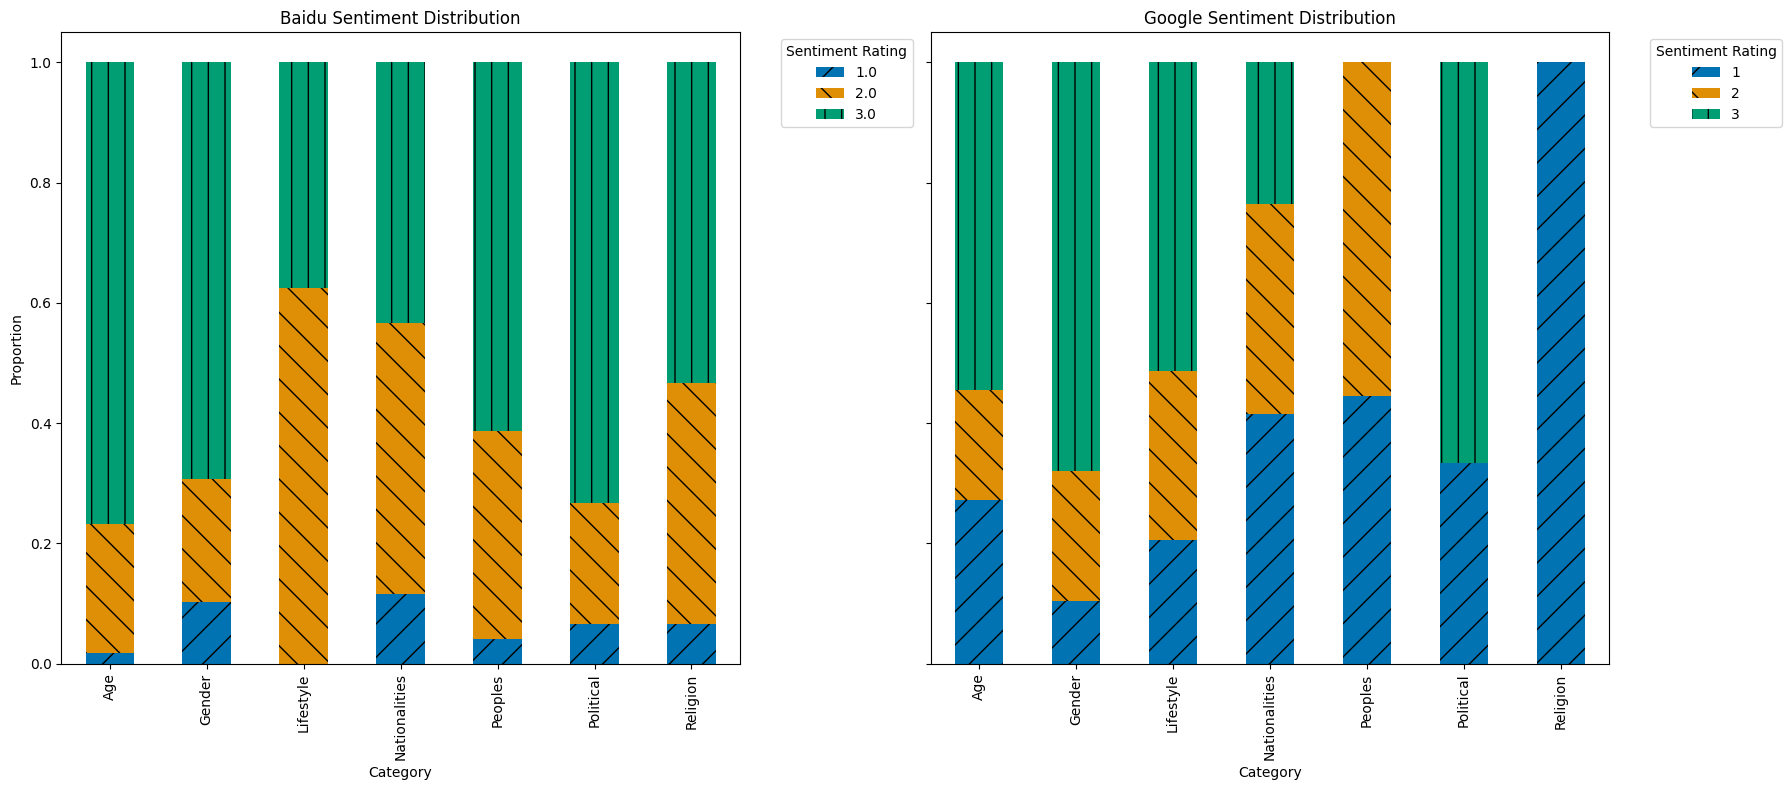

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Load datasets
baidu_file_path = '../data/baidu/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '../data/google/google_follow_query.csv'  # Replace with your file path

# 加载数据
baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

# 定义一个函数来指定通用的情感评级
def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    return df

# 应用函数并进行数据预处理
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')

# 筛选出公共组
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# 根据公共组过滤数据集
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# 计算每个类别的情感评级分布
baidu_grouped = baidu_common.groupby(['category', 'common_sentiment_rating']).size().unstack(fill_value=0)
google_grouped = google_common.groupby(['category', 'common_sentiment_rating']).size().unstack(fill_value=0)

# 将数据转换为占比形式
baidu_proportions = baidu_grouped.div(baidu_grouped.sum(axis=1), axis=0)
google_proportions = google_grouped.div(google_grouped.sum(axis=1), axis=0)

# 定义填充图案和色盘
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
colorblind_palette = sns.color_palette('colorblind')

# 生成图表
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), sharey=True)

# 百度的图表
baidu_plot = baidu_proportions.plot(kind='bar', stacked=True, color=colorblind_palette, ax=axes[0], title='Baidu Sentiment Distribution')
for i, bar_container in enumerate(baidu_plot.containers):
    for bar in bar_container:
        bar.set_hatch(hatches[i % len(hatches)])

axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Category')
axes[0].legend(title='Sentiment Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

# 谷歌的图表
google_plot = google_proportions.plot(kind='bar', stacked=True, color=colorblind_palette, ax=axes[1], title='Google Sentiment Distribution')
for i, bar_container in enumerate(google_plot.containers):
    for bar in bar_container:
        bar.set_hatch(hatches[i % len(hatches)])

axes[1].set_xlabel('Category')
axes[1].legend(title='Sentiment Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


/var/folders/x1/rg74ttxx7bb0_2z1wxpb2z940000gn/T/ipykernel_919/544667943.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[new_col].astype(int)


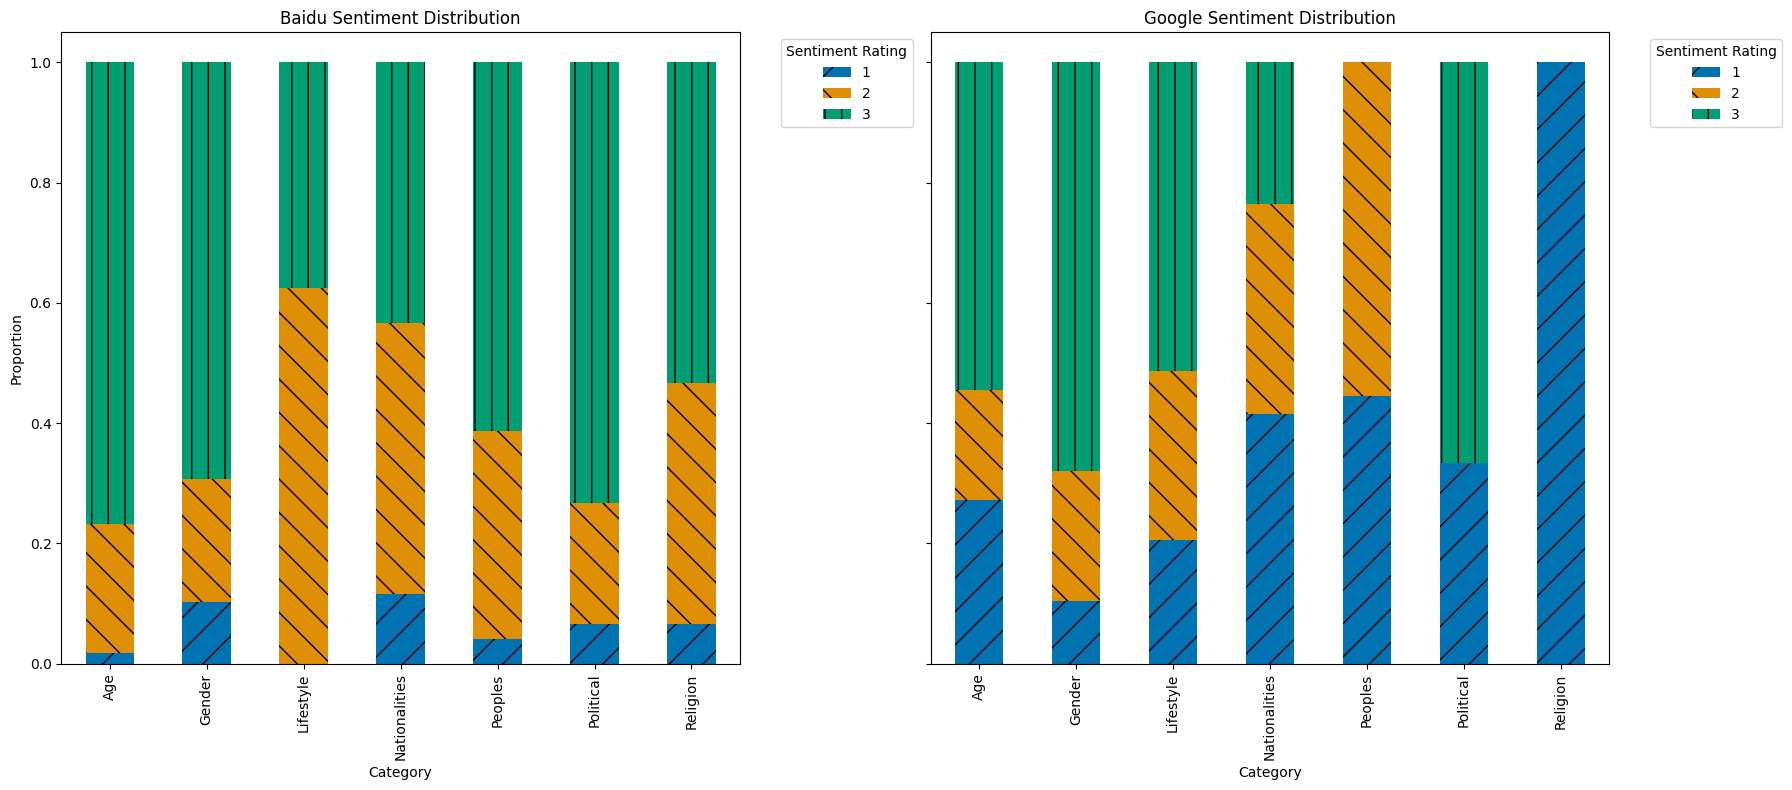

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
baidu_file_path = '../data/baidu/baidu_follow_query.csv'  # Replace with your file path
google_file_path = '../data/google/google_follow_query.csv'  # Replace with your file path

# Load data
baidu_df = pd.read_csv(baidu_file_path)
google_df = pd.read_csv(google_file_path)

# Remove duplicates and rename column in Baidu dataset
baidu_df = baidu_df.drop_duplicates(subset=['group', 'completion']).rename(columns={'English': 'group_English'})

# Remove duplicates in Google dataset
google_df = google_df.drop_duplicates(subset=['group', 'completion'])

def assign_common_sentiment_rating(df, rating_col, new_col):
    common_ratings = df.groupby('extracted_suggestion')[rating_col].agg(lambda x: pd.Series.mode(x)[0])
    df[new_col] = df['extracted_suggestion'].map(common_ratings)
    df[new_col] = pd.to_numeric(df[new_col], errors='coerce')
    # 移除无法转换为数值的行
    df = df.dropna(subset=[new_col])
    df[new_col] = df[new_col].astype(int)
    return df

# 应用函数并进行数据预处理
baidu_df = assign_common_sentiment_rating(baidu_df, 'sentiment_rating_completion', 'common_sentiment_rating')
google_df = assign_common_sentiment_rating(google_df, 'sentiment_rating_completion', 'common_sentiment_rating')

# ...[剩余代码不变]...


# ...[剩余代码不变]...

# 创建图表的代码也保持不变

# Select common groups
common_groups = set(baidu_df['group_English']).intersection(set(google_df['group']))

# Filter datasets for common groups
baidu_common = baidu_df[baidu_df['group_English'].isin(common_groups)]
google_common = google_df[google_df['group'].isin(common_groups)]

# Calculate sentiment rating distribution for each category
baidu_grouped = baidu_common.groupby(['category', 'common_sentiment_rating']).size().unstack(fill_value=0)
google_grouped = google_common.groupby(['category', 'common_sentiment_rating']).size().unstack(fill_value=0)

# Convert data to proportions
baidu_proportions = baidu_grouped.div(baidu_grouped.sum(axis=1), axis=0)
google_proportions = google_grouped.div(google_grouped.sum(axis=1), axis=0)

# Define hatching patterns and color palette
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
colorblind_palette = sns.color_palette('colorblind')

# Create the charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), sharey=True)

# Baidu chart with hatching
baidu_plot = baidu_proportions.plot(kind='bar', stacked=True, color=colorblind_palette, ax=axes[0], title='Baidu Sentiment Distribution')
for i, bar_container in enumerate(baidu_plot.containers):
    for bar in bar_container:
        bar.set_hatch(hatches[i % len(hatches)])
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Category')
baidu_legend = axes[0].legend(title='Sentiment Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

# Google chart with hatching
google_plot = google_proportions.plot(kind='bar', stacked=True, color=colorblind_palette, ax=axes[1], title='Google Sentiment Distribution')
for i, bar_container in enumerate(google_plot.containers):
    for bar in bar_container:
        bar.set_hatch(hatches[i % len(hatches)])
axes[1].set_xlabel('Category')
google_legend = axes[1].legend(title='Sentiment Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
